Flowchart for the whole process
1. Define dictionary
2. Define polytope
3. Function for computing the set of possible normals at given point
4. Function for sampling new point given some points on the polytope
5. Function for running the global optimization loop

### Changes in the old code
1. Replace problem dictionary by Class/OOP approach
2. Data Storage in Final Code to be replaced by dataframe based storage
3. Plotting functions can be improved.
4. No need for any Forward modelling

In [27]:
#@title Install Required Libraries
%%capture
!pip install pygad
!pip install gradient_free_optimizers
!pip install line_profiler
!pip install shgo
%load_ext line_profiler
import numpy as np
from scipy.spatial import HalfspaceIntersection, ConvexHull
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# The link below can be referred for more information about profiling the code line by line
# https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb#scrollTo=lRMD7pePczP1
# https://stackoverflow.com/questions/70303330/how-can-i-do-lprun-work-on-nested-function-in-python

In [2]:
#@title Domain Class
class Domain:
    def __init__(self, dim):
        self.dim = dim

    def contains(self, point):
        raise NotImplementedError("This method should be implemented by subclasses.")


In [3]:
#@title Polytope Class
class Polytope(Domain):
    def __init__(self, A, b):
        """
        A: (n_constraints, dim) numpy array
        b: (n_constraints,) numpy array
        Represents: Ax + b < 0
        """
        super().__init__(A.shape[1])
        self.A = A
        self.b = b

    def contains(self, point, tol = 1e-6):
        return np.all(self.A @ point + self.b < tol)

    def boundary_mask(self, point, tol=1e-6):
        """
        Returns a boolean mask of constraints that are approximately zero.
        """
        vals = self.A @ point + self.b
        return np.abs(vals) < tol

    def is_on_boundary(self, point, tol=1e-6):
        return np.any(self.boundary_mask(point, tol)) and self.contains(point)

    def num_active_constraints(self, point, tol=1e-6):
        return np.sum(self.boundary_mask(point, tol))

    def get_vertices(self, interior_point=None):
        """
        Returns vertices of the polytope.
        Requires an interior point. If not given, tries to find one.
        """
        if interior_point is None:
            interior_point = self._find_interior_point()
        hs = np.hstack([self.A, self.b[:, None]])
        hs_intersection = HalfspaceIntersection(hs, interior_point)
        return hs_intersection.intersections

    def _find_interior_point(self):
        """
        Solves LP to find a point strictly inside the polytope.
        """
        c = np.zeros(self.dim)
        res = linprog(c, A_ub=self.A, b_ub=-self.b - 1e-3)  # Slightly inside
        if not res.success:
            raise ValueError("Polytope appears to be empty or degenerate.")
        return res.x

    def classify_point(self, point, tol=1e-6):
        """
        Returns a string describing whether the point is inside, on face, edge, or vertex.
        """
        if not self.contains(point):
            return "outside"
        num = self.num_active_constraints(point, tol)
        if num == 0:
            return "interior"
        elif num == 1:
            return "face"
        elif num == 2:
            return "edge"
        else:
            return "vertex or corner"

    def sample_boundary(self, n_points=1000, method='rejection'):
        if method == 'rejection':
            return self._sample_boundary_rejection(n_points)
        else:
            raise NotImplementedError("Only rejection sampling implemented.")

    def _sample_boundary_rejection(self, n_points):
        """
        Naive method: Uniformly samples in a bounding box, keeps those on the boundary.
        """
        bbox_min, bbox_max = self._get_bounding_box()
        points = []
        attempts = 0
        while len(points) < n_points and attempts < 1e5:
            rand_pt = np.random.uniform(bbox_min, bbox_max)
            if self.is_on_boundary(rand_pt):
                points.append(rand_pt)
            attempts += 1
        return np.array(points)

    def _get_bounding_box(self):
        """
        Compute a crude bounding box using LP
        """
        mins = []
        maxs = []
        for i in range(self.dim):
            c = np.zeros(self.dim)
            c[i] = 1
            res_min = linprog(c, A_ub=self.A, b_ub=-self.b)
            res_max = linprog(-c, A_ub=self.A, b_ub=-self.b)
            if not res_min.success or not res_max.success:
                raise ValueError("Unable to compute bounding box.")
            mins.append(res_min.x[i])
            maxs.append(res_max.x[i])
        return np.array(mins), np.array(maxs)

    def get_facets(self):
        """
        Returns the flat surfaces (facets) of the polytope as sets of vertices.
        """
        verts = self.get_vertices()
        hull = ConvexHull(verts)
        return hull.simplices  # indices of vertices that form each face

    def initialize_facet_sampling(self):
        """
        Precompute edges and sampling probabilities for facet sampling.
        Stores:
          - self._edges: array of edge endpoints
          - self._edge_probs: probabilities proportional to edge lengths
        """
        if self.dim != 2:
            raise NotImplementedError("Facet sampling implemented only for 2D.")

        verts = self.get_vertices()
        hull = ConvexHull(verts)
        self._edges = verts[hull.simplices]

        lengths = [np.linalg.norm(edge[0] - edge[1]) for edge in self._edges]
        total_length = sum(lengths)
        self._edge_probs = [l / total_length for l in lengths]

    def compute_static_mesh(self, N = 100):
        verts = self.get_vertices()
        hull = ConvexHull(verts)
        self._edges = verts[hull.simplices]
        num_edges = len(self._edges)
        points_per_edge = int(N/num_edges)
        list_points = []
        for edge in self._edges:
          a, b = edge
          point_lambdas = np.arange(1, points_per_edge + 1)/points_per_edge
          for i in point_lambdas:
            point = i*a + (1 - i)*b
            list_points.append(point)
        return np.array(list_points)


    def sample_boundary_facet_point(self):
        """
        Sample a single point uniformly from the boundary using precomputed edge probabilities.
        Must call initialize_facet_sampling() before using this.
        """
        if not hasattr(self, '_edges') or not hasattr(self, '_edge_probs'):
            raise RuntimeError("Must call initialize_facet_sampling() before sampling.")

        edge_idx = np.random.choice(len(self._edges), p=self._edge_probs)
        a, b = self._edges[edge_idx]
        t = np.random.uniform()
        pt = (1 - t) * a + t * b
        return pt


    def sample_boundary_facet(self, n_points=100):
        """
        Sample points uniformly from the boundary of a 2D polytope using facet sampling.
        Assumes 2D polytope.
        """
        if self.dim != 2:
            raise NotImplementedError("Facet sampling implemented only for 2D.")

        verts = self.get_vertices()
        hull = ConvexHull(verts)
        edges = verts[hull.simplices]

        # Length of each edge
        lengths = [np.linalg.norm(edge[0] - edge[1]) for edge in edges]
        total_length = sum(lengths)
        probs = [l / total_length for l in lengths]  # probability of selecting each edge

        sampled_points = []
        while len(sampled_points) < n_points:
            # Select edge with probability proportional to length
            edge_idx = np.random.choice(len(edges), p=probs)
            a, b = edges[edge_idx]
            t = np.random.uniform()
            pt = (1 - t) * a + t * b
            sampled_points.append(pt)

        return np.array(sampled_points)

    def get_normal_basis(self, x):
        bdry_mask = self.boundary_mask(x)
        list_basis = []
        for i in range(0, len(bdry_mask)):
          if(bdry_mask[i] == True):
            list_basis.append(self.A[i])
        return list_basis

    def compute_normals(self, x_array):
        grad_x_list = []
        for i in range(0, x_array.shape[0]):
          grad_x_list.append(get_normal_basis(self, x_array[i]))
        return grad_x_list


    def plot_with_samples(self, sample_points=None, show_vertices=True, color='red', title='Polytope with Samples'):
        """
        Plots the 2D polytope and overlays optional sampled boundary points.

        Parameters:
        - sample_points: np.ndarray of shape (n, 2), boundary points to plot.
        - show_vertices: bool, whether to show the polytope's vertices.
        - color: color of the sample points.
        - title: plot title.
        """
        if self.dim != 2:
            raise NotImplementedError("Plotting is only supported for 2D polytopes.")

        verts = self.get_vertices()
        hull = ConvexHull(verts)

        plt.figure(figsize=(6, 6))

        # Plot polytope edges
        for simplex in hull.simplices:
            plt.plot(verts[simplex, 0], verts[simplex, 1], 'k-')

        # Plot vertices
        if show_vertices:
            plt.plot(verts[:, 0], verts[:, 1], 'ko', label='Vertices')

        # Plot sampled boundary points
        if sample_points is not None:
            plt.scatter(sample_points[:, 0], sample_points[:, 1], s=20, c=color, label='Sampled Points')

        plt.gca().set_aspect('equal')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()


    def plot(self, show_normals=False, ax=None):
        """
        Plot a 2D polytope: shows the boundary (edges) and vertices.
        Only works if dim == 2.
        """
        if self.dim != 2:
            raise ValueError("Plotting is only supported for 2D polytopes.")

        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))

        # Get the vertices
        verts = self.get_vertices()

        # Get the convex hull to connect the vertices in the right order
        hull = ConvexHull(verts)

        # Plot the edges
        for simplex in hull.simplices:
            ax.plot(verts[simplex, 0], verts[simplex, 1], 'k-')

        # Plot filled polygon
        polygon = Polygon(verts[hull.vertices], closed=True, alpha=0.2, color='lightblue')
        ax.add_patch(polygon)

        # Plot the vertices
        ax.plot(verts[:, 0], verts[:, 1], 'ro')

        # Optionally show normals to constraints
        if show_normals:
            # Find a representative point (interior) and plot normal arrows
            center = np.mean(verts, axis=0)
            for i in range(self.A.shape[0]):
                a = self.A[i]
                b = self.b[i]
                # Choose a point on the line (by projecting center onto the hyperplane)
                d = -(a @ center + b)
                proj = center + d * a / np.linalg.norm(a)
                ax.arrow(proj[0], proj[1], a[0]*0.2, a[1]*0.2, head_width=0.05, color='gray')

        ax.set_aspect('equal')
        ax.set_title("2D Polytope")
        ax.grid(True)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        plt.show()


def get_normal_basis(polytope, x):
  bdry_mask = polytope.boundary_mask(x)
  list_basis = []
  for i in range(0, len(bdry_mask)):
    if(bdry_mask[i] == True):
      list_basis.append(polytope.A[i])
  return list_basis


def compute_normals(polytope, x_array):
  grad_x_list = []
  for i in range(0, x_array.shape[0]):
    grad_x_list.append(get_normal_basis(polytope, x_array[i]))
  return grad_x_list


(100, 2)


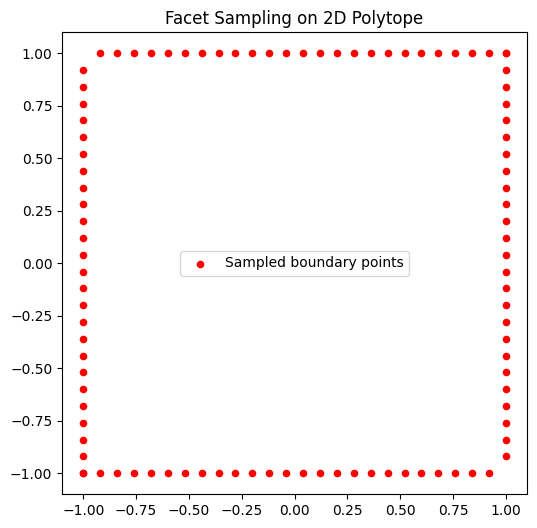

In [4]:
#@title Define A,b and plot
m = 4
theta = 2 * np.pi / m
inlist = []
for i in range(m):
    inlist.append([np.sin(i * theta), np.cos(i * theta)])
A = np.array(inlist)
b = np.array([-1 for _ in range(m)])

# Define the Polytope class (include earlier methods here)
# Include .plot(), .get_vertices(), etc. (you already have these)

# Create the polytope
p = Polytope(A, b)

# Sample 100 points using facet method
# samples = p.sample_boundary_facet(100)

# # # Plot on top of the polytope
# plt.figure(figsize=(6,6))
# p.plot()
# plt.scatter(samples[:, 0], samples[:, 1], s=20, c='red', label='Sampled boundary points')
# plt.legend()
# plt.title("Facet Sampling on 2D Polytope")
# plt.show()

# print(f"Type of samples is {samples[0].__class__} and shape is {samples[0].shape} and samples is {samples[0]}")

polytope = p
# polytope.initialize_facet_sampling()

points = polytope.compute_static_mesh()
print(points.shape)
samples = points
plt.figure(figsize=(6,6))
#p.plot()
plt.scatter(samples[:, 0], samples[:, 1], s=20, c='red', label='Sampled boundary points')
plt.legend()
plt.title("Facet Sampling on 2D Polytope")
plt.show()


In [5]:
#@title Check directory of Polytope
# print(dir(p))
# print(p.boundary_mask(np.array([1, 1])))
# # print(p.contains(np.array([0.5, 0])))
# # print(p.contains(np.array([0.5, 1.5])))
# # print(p.contains(np.array([0.5, -0.5])))
# # print(p.contains(np.array([0.5, -1.5])))
# # print(p.contains(np.array([1, -1])))
# # print(p.classify_point(np.array([0.5, 0])))
# # print(p.classify_point(np.array([0.5, 1.5])))
# # print(p.classify_point(np.array([0.5, -0.5])))
# # print(p.classify_point(np.array([0.5, -1.5])))
# # print(p.classify_point(np.array([1,-1])))
# print(p.dim)
# print(p.get_facets())
# print(p.get_vertices())
# print(p.A)
# print(p.b)
# print(p.boundary_mask(np.array([1, 1])))
# print(p.num_active_constraints(np.array([1.1, 0.1])))
# print(p.is_on_boundary(np.array([1.1, 0.1])))

### Great Reference --> CornerFinder
https://itsiweinstock.com/posts/linear-system-corners/


### Setting up Experiment 1

In [8]:
#@title Lambdified Dictionary
import numpy as np
from sympy import Array, symbols, lambdify
x1, x2 = symbols('x1 x2')


raw_dict = {
    0:Array([1, 0]), \
    1:Array([0, 1]), \
    2:Array([x1, 0]), \
    3:Array([x2, 0]), \
    4:Array([0, x1]), \
    5:Array([0, x2]), \
}

lambdified_dict = {}

for key in raw_dict.keys():
  lambdified_dict[key] = lambdify([x1, x2], raw_dict[key], 'numpy')
len_dict = len(lambdified_dict)
# num_v_points = 1*len_dict
# dim_theta = num_v_points*(dim_v - 1)
# max_bound_array = 2*np.pi*np.ones(dim_theta)
# min_bound_array = np.zeros(dim_theta)
# bounds_array = (min_bound_array, max_bound_array)


In [11]:
#@title Set Up GA parameters
#GA Parameters
num_genes = 2
num_generations = 5
sol_per_pop = 40
num_parents_mating = sol_per_pop
keep_elitism = 1
GA_low_bound = 0
GA_high_bound = 2*np.pi
parent_selection_type = 'rws'
crossover_type = "single_point"
mutation_type = "adaptive"
mutation_percent_genes = [12, 4]

In [12]:
#@title f(x),g(x),u(x)
def f_of_x(x):
  #Input: \x in R^v
  #Output: f(\x) in R^v

  f  = np.zeros(x.shape[0])
  f[0] = x[0]
  f[1] = x[1]
  return f

def g_of_x(x):
  #Input: \x in R^v
  #output: g(x) in R^(vxm)
  theta = 3*np.pi/4
  g = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
  return g

def u_of_x(x, eta, lambdified_dict):
  #Input: \x in R^v, \lambdified_dict,
  #Output: u(x) in R^m
  u_x = np.zeros(x.shape[0])
  for i in range(0, eta.shape[0]):
    u_x += eta[i]*lambdified_dict[i](*x)
  return u_x

def diff_eqn(x, eta, lambdified_dict):
  #Input: A point \x, \grad_x --> for the stochastic case
  #Do we need max_noise? --> should it not be a constant? --> maybe in an OOP approach it wont be needed.
  #Output: \x_dot = f(x) + g(x)u(x) + w(x)
  #What we know --> f(.), g(.), w(.)
  #Note that here \x is in R^v
  #\u is in R^m
  #and therefore g(.) is in R^(v x m)
  #Right now just assume a zero-noise version --> w = 0
  #Further, we are removing k from the version since we just want to do this with a single point x
  # Initialize everything --> Even this code can just be an external pull to a function f, which is what we shall do
  # Also, note that in the arbitrary case, g becomes a function of x --> again use a function approach
  # the same can be done for u(x)
  f = f_of_x(x)
  g = g_of_x(x)
  u = u_of_x(x, eta, lambdified_dict)
  g_times_u = np.dot(g, u)
  return f + g_times_u

In [15]:
#@title Inner Optimization
import numpy as np
from scipy.optimize import minimize
import time
from shgo import shgo
import random
#import gradient_free_optimizers as gradfree

def inner_minimization(x_array,  grad_x_list, lambdified_dict, static_mesh, mesh_normals):


    #Basically, we want to solve the inner minimization problem which says
    #Given points (x_1, x_2, x_3, ... , x_n) --> first set up a constraint corresponding to each x_i
    #The feedback function should be such that all the n constraints need to be satisfied.
    #In addition to this, in order to ensure convexity and convergence, we add an objective function to the mix.
    #The eta are only called into the inner minimization since they are the ones over which we actually minimize.
    #We are not specifying any bound on eta --> let them go from (-inf, inf)
    #For now, we are writing the code assuming that there is only one boundary normal at every point.
    #Later on we can scale it to cones.
    EPSILON_HAMILTONIAN = 1e-5
    MAX_VAL =  10e8

    def objective_function(eta):
      sum = 0
      for i in range(static_mesh.shape[0]):
        x_dot_noisy = diff_eqn(static_mesh[i], eta, lambdified_dict)
        for basis_func in mesh_normals[i]:
          dot_product = np.dot(basis_func, x_dot_noisy)
          sum += dot_product
      return sum

    # def objective_function(eta):
    #   sum = 0
    #   for i in range(0, len(eta)):
    #     sum += np.abs(eta[i]**2)
    #   return sum

    def bounds_function(i):
        return (-np.inf, np.inf)

    def constraint_function1(eta, k):
      x_dot_noisy = diff_eqn(x_array[k], eta, lambdified_dict)
      # This should never be empty
      # If it is empty constraint will anyway get satisfied
      max_dot_product = -1e8
      for basis_func in grad_x_list[k]:
        #print(f"Basis function is {basis_func}")
        dot_product = np.dot(basis_func, x_dot_noisy)
        if(dot_product > max_dot_product):
          max_dot_product = dot_product
      return (max_dot_product + EPSILON_HAMILTONIAN)

    def constraint_function2(eta,k):
      norm_eta = np.linalg.norm(eta)
      is_allowed = (norm_eta-2)
      return is_allowed

    bounds = [bounds_function(i) for i in range(0, len(lambdified_dict))] #minimise

    constraint_functions1  = [lambda eta, k=k: -constraint_function1(eta, k) for k in range(x_array.shape[0])]
    constraint_functions2  = [lambda eta, k=k: -constraint_function2(eta, k) for k in range(x_array.shape[0])]

    merged_constraint_functions = constraint_functions1 + constraint_functions2

    constraints = [{'type': 'ineq', 'fun': func} for func in merged_constraint_functions]

    initial_guess = [1]*len(lambdified_dict)
    for k in range(x_array.shape[0]):
      val = constraint_function1(np.zeros(len(lambdified_dict)), k)
      # print(f"Constraint1 value at k={k} with zero eta: {val}")


    #Here, we could actually compute the center of whatever convex body we are choosing and then try\
    #and make it point towards the center of that body ---> Sounds like something that will optimize it quite well
    #initial_guess = [c1/a1**2, c2/a2**2, -1/a1**2,0,0,-1/a2**2,0,0,0,0]
    # initial_guess = [1, 1, -1,0,0,-1,0,0,0,0]

    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, \
                      options={'disp': False})
    #print(result)
    end_time_in = time.time()
    if result.success == True:
      return result.fun, result.x
    elif result.success == False:
      print("Printing result ====================================================================================")
      print(result)
      print(f"Failed to solve inner optimization. Error message: f{result.message}")
      return MAX_VAL, result.x

In [16]:
#@title Polytope Sampler GA
import pygad
import numpy as np

class PolytopeSamplerGA:
    def __init__(self, polytope, num_points, lambdified_dict):
        self.polytope = polytope
        self.num_points = num_points
        self.lambdified_dict = lambdified_dict
        self.polytope.initialize_facet_sampling()
        self.fitness_over_time = []
        self.static_mesh  = self.polytope.compute_static_mesh()
        self.mesh_normals = self.polytope.compute_normals(self.static_mesh)


    def genome_to_points(self, genome):
        points = []
        for i in range(0, len(genome), 2):
            #edge_idx = int(genome[i])%len(self.polytope._edges)
            edge_idx = int(np.clip(genome[i], 0, len(self.polytope._edges) - 1))
            t = np.clip(genome[i+1], 0.0, 1.0)
            a, b = self.polytope._edges[edge_idx]
            pt = (1 - t) * a + t * b
            points.append(pt)
        return np.array(points)

    def fitness_func(self, ga_instance, solution, solution_idx):
        x_array = self.genome_to_points(solution)
        grad_x_list = compute_normals(self.polytope, x_array)
        print(f"Solution at {solution_idx} is {solution}")
        try:
            fitness, _ = inner_minimization(x_array, grad_x_list, self.lambdified_dict, self.static_mesh, self.mesh_normals)
        except Exception as e:
            print(f"Exception in inner optimization: {e}")
            fitness = 1e8

        return fitness  # pygad maximizes

    def on_gen(self, ga_instance):
        self.fitness_over_time.append(ga_instance.best_solution()[1])

    def run(self, num_generations=30, sol_per_pop=10):
        num_genes = self.num_points * 2  # (ai, bi) for each point
        gene_space = []
        gene_type = []
        for i in range(self.num_points):
            gene_space.append({'low': 0, 'high': len(self.polytope._edges)})  # ai
            gene_space.append({'low': 0.0, 'high': 1.0})  # bi
            gene_type.append(int)
            gene_type.append(float)


        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=2,
            fitness_func=self.fitness_func,
            sol_per_pop=sol_per_pop,
            num_genes=num_genes,
            gene_space=gene_space,
            parent_selection_type="rws",
            keep_parents=0,
            crossover_type="single_point",
            mutation_type="random",
            mutation_percent_genes=20,
            gene_type = gene_type,
            on_generation = self.on_gen
        )

        ga_instance.run()

        solution, fitness, _ = ga_instance.best_solution()
        best_points = self.genome_to_points(solution)

        return best_points, -fitness  # converting back to minimization value


In [ ]:
#@title Testing out code
# testx = np.array([[ 1.   ,       1.        ],
#  [ 0.97646856, -1.        ],
#  [-1.         ,-1.        ],
#  [-0.43129612 ,-1.        ]])

genome = [np.int64(1), np.float64(0.029452997944613646), np.int64(1)
 ,np.float64(0.9674043939185889), np.int64(2), np.float64(0.1407915732489744)
 ,np.int64(1) ,np.float64(0.7363522797649129)]

testp = Polytope(A,b)
print(genome)
testsampler = PolytopeSamplerGA(polytope=testp, num_points=4, lambdified_dict=lambdified_dict)

testx = testsampler.genome_to_points(genome)

# gradtestx = compute_normals(testp, testx)
# print(gradtestx)
# raw_dict = {
#     0:Array([1, 0]), \
#     1:Array([0, 1]), \
#     2:Array([x1, 0]), \
#     3:Array([x2, 0]), \
#     4:Array([0, x1]), \
#     5:Array([0, x2]), \
# }
# gradtestx = [[np.array([1., 1.])], [np.array([ 1.2246468e-16, -1.0000000e+00])], [np.array([-1.0000000e+00, -1.8369702e-16])], [np.array([ 1.2246468e-16, -1.0000000e+00])]]

statmesh = testp.compute_static_mesh()
print(testx)

mesh_normals = testp.compute_normals(statmesh)
gradtestx = compute_normals(testp, testx)
print(gradtestx)
print(inner_minimization(testx, gradtestx, lambdified_dict, statmesh, mesh_normals ))
print(np.linalg.norm(np.array([ 0.14476284, -0.08813033,  0.04015353,  0.04473301,  0.01341317,
       -0.08813033])))

In [22]:
#@title Running main loop
m = 7
theta = 2 * np.pi / m
inlist = []
for i in range(m):
    inlist.append([np.sin(i * theta), np.cos(i * theta)])
A = np.array(inlist)
b = np.array([-1 for _ in range(m)])

poly = Polytope(A, b)  # Your polytope
lambdified_dict = lambdified_dict  # Your symbolic vector field
sampler = PolytopeSamplerGA(polytope=poly, num_points=4, lambdified_dict=lambdified_dict)

best_points, best_val = sampler.run(num_generations=5, sol_per_pop= 4)
print("Best Points:", best_points)
print("Minimum Hamiltonian Violation:", best_val)
statmesh = poly.compute_static_mesh()
mesh_normals = poly.compute_normals(statmesh)
gradtestx = compute_normals(poly, best_points)
print(inner_minimization(testx, gradtestx, lambdified_dict, statmesh, mesh_normals ))


Solution at 0 is [np.int64(1) np.float64(0.4923391693091135) np.int64(3)
 np.float64(0.9402964282821508) np.int64(2)
 np.float64(0.30212863875017726) np.int64(4)
 np.float64(0.6759312812248155)]
Solution at 1 is [np.int64(3) np.float64(0.4634458662600909) np.int64(6)
 np.float64(0.26186301646697197) np.int64(1)
 np.float64(0.12529852925300156) np.int64(0)
 np.float64(0.8653772889246464)]
Solution at 2 is [np.int64(4) np.float64(0.8955824263141552) np.int64(5)
 np.float64(0.7834159515736215) np.int64(1) np.float64(0.8775776905712777)
 np.int64(2) np.float64(0.8342748535457531)]
Solution at 3 is [np.int64(4) np.float64(0.659439470823168) np.int64(6)
 np.float64(0.7812041479120485) np.int64(0)
 np.float64(0.05064401163166221) np.int64(0)
 np.float64(0.6682064524415069)]
Solution at 1 is [np.int64(1) 0.0 np.int64(3) np.float64(0.9402964282821508) np.int64(2)
 np.float64(0.30212863875017726) np.int64(4)
 np.float64(0.6759312812248155)]
Solution at 2 is [np.int64(1) np.float64(0.492339169309

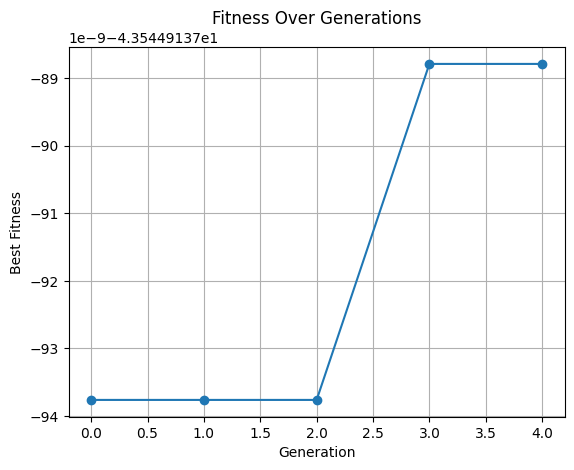

In [23]:
#@title Plot GA Fitness Function
plt.plot(sampler.fitness_over_time, marker='o')
plt.title("Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.grid(True)
plt.show()


[[ 0.29383876 -0.96841097]
 [ 1.06929262  0.19091789]
 [-0.93251995 -0.40832235]
 [ 0.28121629 -0.97448963]]


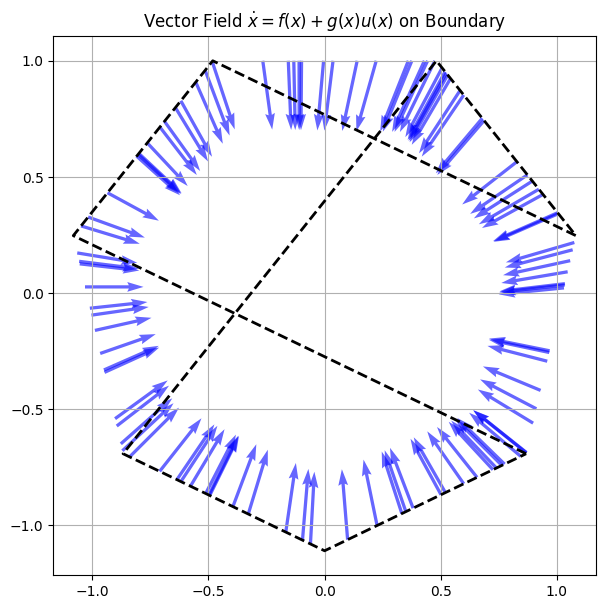

In [26]:
#@title Plot final vector field
import matplotlib.pyplot as plt

def plot_vector_field_on_boundary(polytope, eta, lambdified_dict, density=100):
    # Initialize for facet sampling
    polytope.initialize_facet_sampling()
    # Sample boundary points
    points = []
    vectors = []

    for _ in range(density):
        x = polytope.sample_boundary_facet_point()
        dx = diff_eqn(x, eta, lambdified_dict)
        points.append(x)
        vectors.append(dx)

    points = np.array(points)
    vectors = np.array(vectors)

    # Plot
    plt.figure(figsize=(7, 7))
    plt.quiver(points[:, 0], points[:, 1], vectors[:, 0], vectors[:, 1],
               angles='xy', scale_units='xy', scale=1.5, color='blue', alpha=0.6)

    verts = polytope.get_vertices()
    plt.plot(*zip(*np.vstack((verts, verts[0]))), 'k--', linewidth=2)
    plt.title("Vector Field $\dot{x} = f(x) + g(x)u(x)$ on Boundary")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

print(best_points)
grad_best = compute_normals(poly, best_points)
static_mesh = poly.compute_static_mesh()
mesh_normals = poly.compute_normals(static_mesh)
_, eta = inner_minimization(best_points, grad_best, lambdified_dict, static_mesh, mesh_normals)
plot_vector_field_on_boundary(poly, eta, lambdified_dict)